# **Análise de Dados Após Respetivo Tratamento**

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# matplotlib inline

## Carregar os Dataset de Treino e de Teste

In [2]:
TRAINING_DATASET_SOURCE = '../datasets/training_data.csv'
TEST_DATASET_SOURCE = '../datasets/test_data.csv'

In [3]:
train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

## Aplicar Tratamento de Dados

In [4]:
from pandas import DataFrame
from sklearn.preprocessing import KBinsDiscretizer
import statistics
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

dropped_columns = ['city_name','avg_precipitation', 'magnitude_of_delay']
holidays_in_guimaraes = pd.read_csv('../datasets/national_holidays_2021.csv')

# Não tratar outliers de 'affected_roads', 'hour', 'day', 'month', 'weekday', 'weekend', 'holiday'
numeric_columns = ['avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'luminosity']

categorical_to_numerical = {
    'luminosity': {
        'LOW_LIGHT': 0,
        'LIGHT': 1,
        'DARK': 2
    },
    'avg_rain': {
        'Sem Chuva': 0,
        'chuva fraca': 1,
        'chuva moderada': 1,
        'chuva forte': 1,
    }
}

In [5]:
### Criar 5 bins para a variável hour
def create_bins_for_hour(df: DataFrame):
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    est.fit(df['hour'].to_frame())
    df['hour'] = est.transform(df['hour'].to_frame())
    return df['hour']

### Verificar se a data se refere a um feriado português.
def is_it_holiday(month: int, day: int):
    is_holiday = 0
    for date in holidays_in_guimaraes['date']:
        date_splitted = str(date).split('-')
        month_holiday = date_splitted[1]
        day_holiday = date_splitted[2]
        if str(day) == day_holiday and str(month) == month_holiday:
            is_holiday = 1
            break
    return is_holiday

In [6]:
# noinspection PyPep8Naming
def decision_tree_data_preparation(df: DataFrame) -> DataFrame:
    prep_df = df.drop(dropped_columns, axis=1)
    prep_df.drop_duplicates()

    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['record_date'])

    prep_df['hour'] = record_date.hour
    prep_df['day'] = record_date.day
    prep_df['month'] = record_date.month
    prep_df['weekday'] = record_date.weekday

    ### Verificar se a data se refere a um dia de fim-de-semana ou não.
    weekend = []
    for weekday in prep_df['weekday']:
        if weekday == 5 or weekday == 6:
            weekend.append(1)
        else:
            weekend.append(0)
    prep_df['weekend'] = weekend

    prep_df['hour'] = create_bins_for_hour(prep_df)

    is_holiday = []
    i = 0
    while i < len(prep_df):
        is_holiday.append(is_it_holiday(prep_df['month'][i], prep_df['day'][i]))
        i += 1
    prep_df["is_holiday"] = is_holiday

    prep_df.drop(columns=['record_date'], inplace=True)

    train_df['affected_roads'] = train_df['affected_roads'].fillna(train_df['affected_roads'].mode().iloc[0])

    roads_already_added = []
    i = 0
    for line in prep_df['affected_roads']:
        unique_roads = set(str(line).split(','))
        for valid_road in unique_roads:
            if (valid_road != ''):
                multiple_roads = valid_road.split(' - ')
                if(len(multiple_roads) > 1):
                    if (multiple_roads[0] not in roads_already_added):
                        roads_already_added.append(multiple_roads[0])
                        prep_df[f'{multiple_roads[0]}'] = [0] * len(prep_df)
                        prep_df[f'{multiple_roads[0]}'][i] = 1     # 1 significa que essa rua foi afetada
                    else:
                        prep_df[f'{multiple_roads[0]}'][i] = 1     # 1 significa que essa rua foi afetada
                    if (multiple_roads[1] not in roads_already_added):
                        roads_already_added.append(multiple_roads[1])
                        prep_df[f'{multiple_roads[1]}'] = [0] * len(prep_df)
                        prep_df[f'{multiple_roads[1]}'][i] = 1     # 1 significa que essa rua foi afetada
                    else:
                        prep_df[f'{multiple_roads[1]}'][i] = 1     # 1 significa que essa rua foi afetada
                else:
                    if (valid_road not in roads_already_added):
                        roads_already_added.append(valid_road)
                        prep_df[f'{valid_road}'] = [0] * len(prep_df)
                        prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
                    elif (valid_road in roads_already_added):
                        prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
                    else:
                        pass
        i+=1

    prep_df.drop(columns=['nan'], inplace=True)

    ### Ao analisar o resultado pós-tratamento, verificámos que a feature 'affected_roads' tinha alta correlação com 'delay_in_minutes'
    prep_df.drop(columns=['affected_roads'], inplace=True)

    ### Converter a feature 'delay_in_seconds' para 'delay_in_minutes' de modo a reduzir o intervalo de valores
    delay_in_minutes = []
    for seconds in prep_df['delay_in_seconds']:
        minutes = seconds / 60
        delay_in_minutes.append(minutes)

    prep_df.drop(columns=['delay_in_seconds'], inplace=True)
    prep_df['delay_in_minutes'] = delay_in_minutes

    # Normalizar o intervalo de valores de delay_in_minutes
    delay_2D = np.array(prep_df['delay_in_minutes']).reshape(-1, 1)
    scaler = StandardScaler()
    normalized_delay_2D = scaler.fit_transform(delay_2D)
    prep_df['delay_in_minutes'] = np.array(normalized_delay_2D).flatten()
    
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    i = 0
    for num in numeric_columns:
        median = np.median(prep_df[num])
        prep_df.loc[prep_df[num] <= whiskers[i][1], num] = median
        prep_df.loc[prep_df[num] >= whiskers[i][2], num] = median
        i = i + 1

    return prep_df

In [7]:
prep_df = decision_tree_data_preparation(train_df)

/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_13629/2010206455.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_13629/2010206455.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_13629/2010206455.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

## Exploração dos Dados 

In [9]:
prep_df.head()
prep_df.describe()
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   luminosity        5000 non-null   int64  
 1   avg_temperature   5000 non-null   float64
 2   avg_atm_pressure  5000 non-null   float64
 3   avg_humidity      5000 non-null   float64
 4   avg_wind_speed    5000 non-null   float64
 5   avg_rain          5000 non-null   int64  
 6   incidents         5000 non-null   object 
 7   hour              5000 non-null   float64
 8   day               5000 non-null   int64  
 9   month             5000 non-null   int64  
 10  weekday           5000 non-null   int64  
 11  weekend           5000 non-null   int64  
 12  is_holiday        5000 non-null   int64  
 13  N101              5000 non-null   int64  
 14  N105              5000 non-null   int64  
 15  R206              5000 non-null   int64  
 16  N206              5000 non-null   int64  


- Definição do primeiro e do terceiro quartis
- Definição dos valores máximo (*upper*) e mínimo (*lower*)

In [10]:
numeric_columns = ['avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'avg_rain', 'luminosity', 'hour', 'day', 'month', 'weekday', 'weekend', 'is_holiday', 'delay_in_minutes']
whiskers = []

for num in numeric_columns:
    Q1 = prep_df[num].quantile(0.25)
    Q3 = prep_df[num].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    whiskers.append((num,lower,upper))

print(whiskers)

[('avg_temperature', 2.0, 26.0), ('avg_atm_pressure', 1004.5, 1032.5), ('avg_humidity', 22.5, 130.5), ('avg_wind_speed', -3.0, 5.0), ('avg_rain', 0.0, 0.0), ('luminosity', -0.5, 3.5), ('hour', -2.0, 6.0), ('day', -14.5, 45.5), ('month', -5.0, 19.0), ('weekday', -5.0, 11.0), ('weekend', -1.5, 2.5), ('is_holiday', 0.0, 0.0), ('delay_in_minutes', -0.5404469824402994, 0.01448576036864424)]


## Visualização gráfica dos dados

- Matriz de correlação para valores numéricos

/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_13629/137305099.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlationMatrix = prep_df.corr()


<AxesSubplot: >

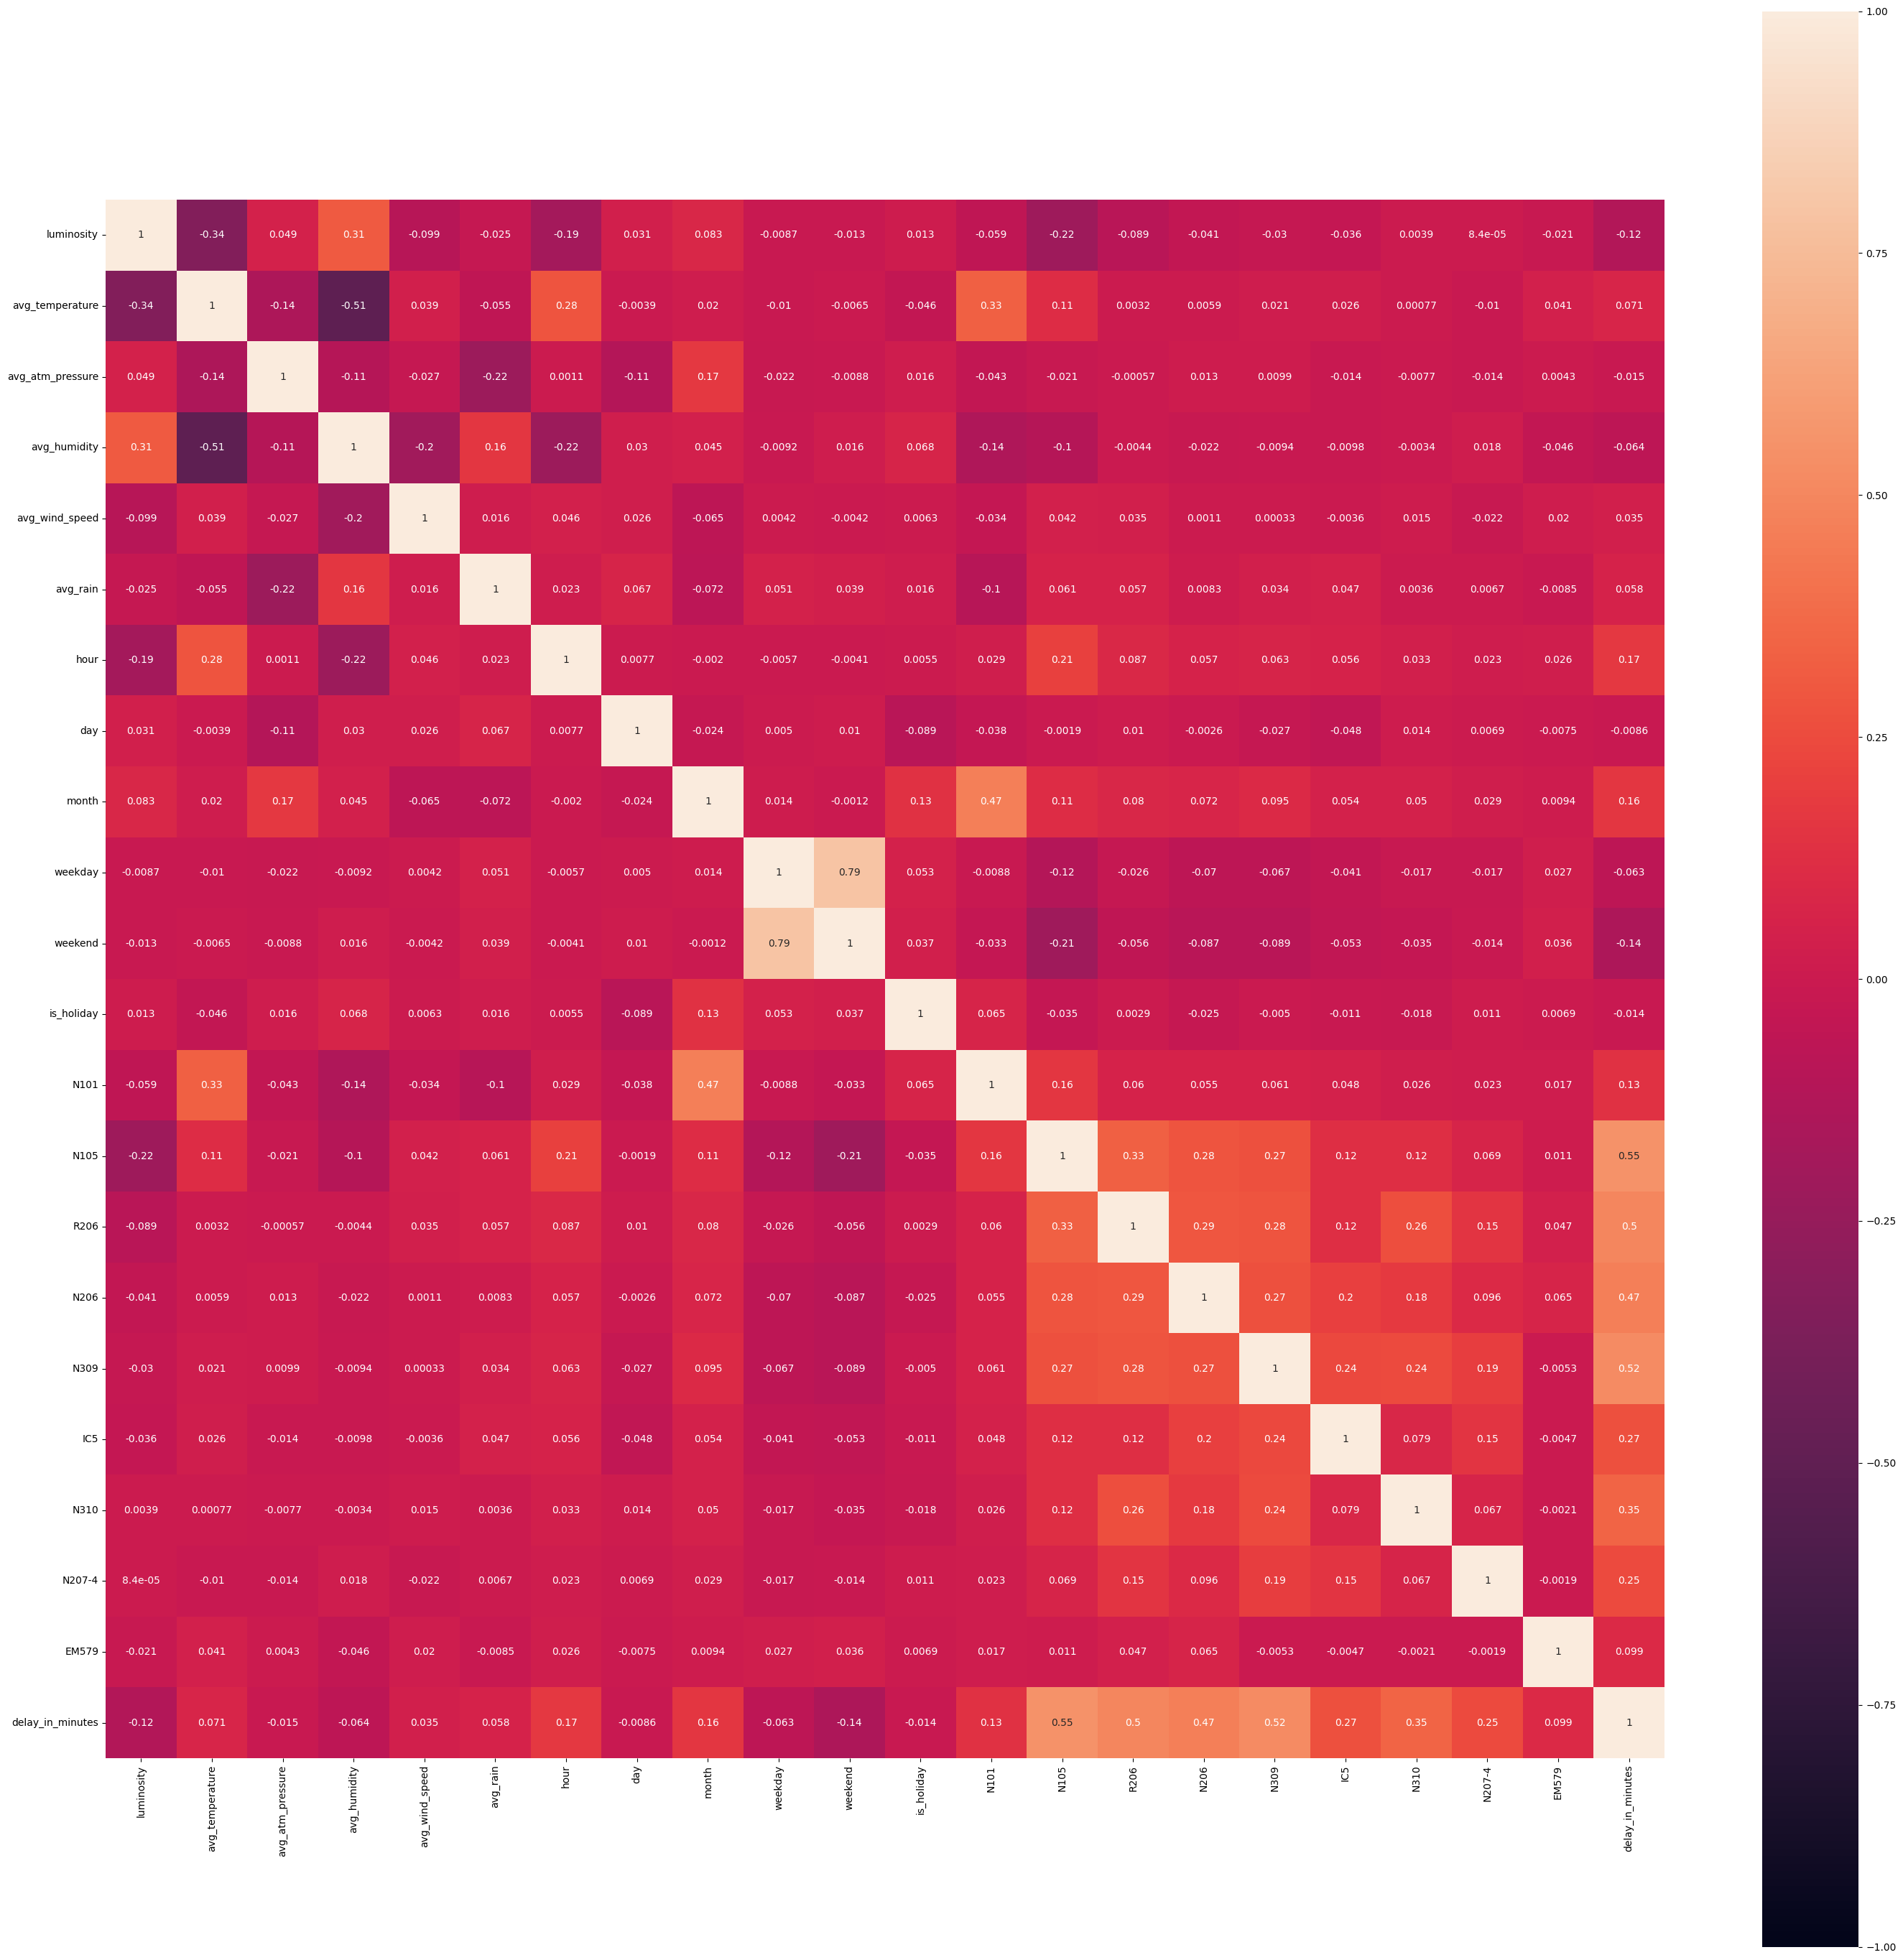

In [11]:
correlationMatrix = prep_df.corr()
f, ax = plt.subplots(figsize=(35,35))
sns.heatmap(correlationMatrix, vmin=-1, vmax=1, square=True, annot=True)

- Distribuições bivariadas de pares num conjunto de dados

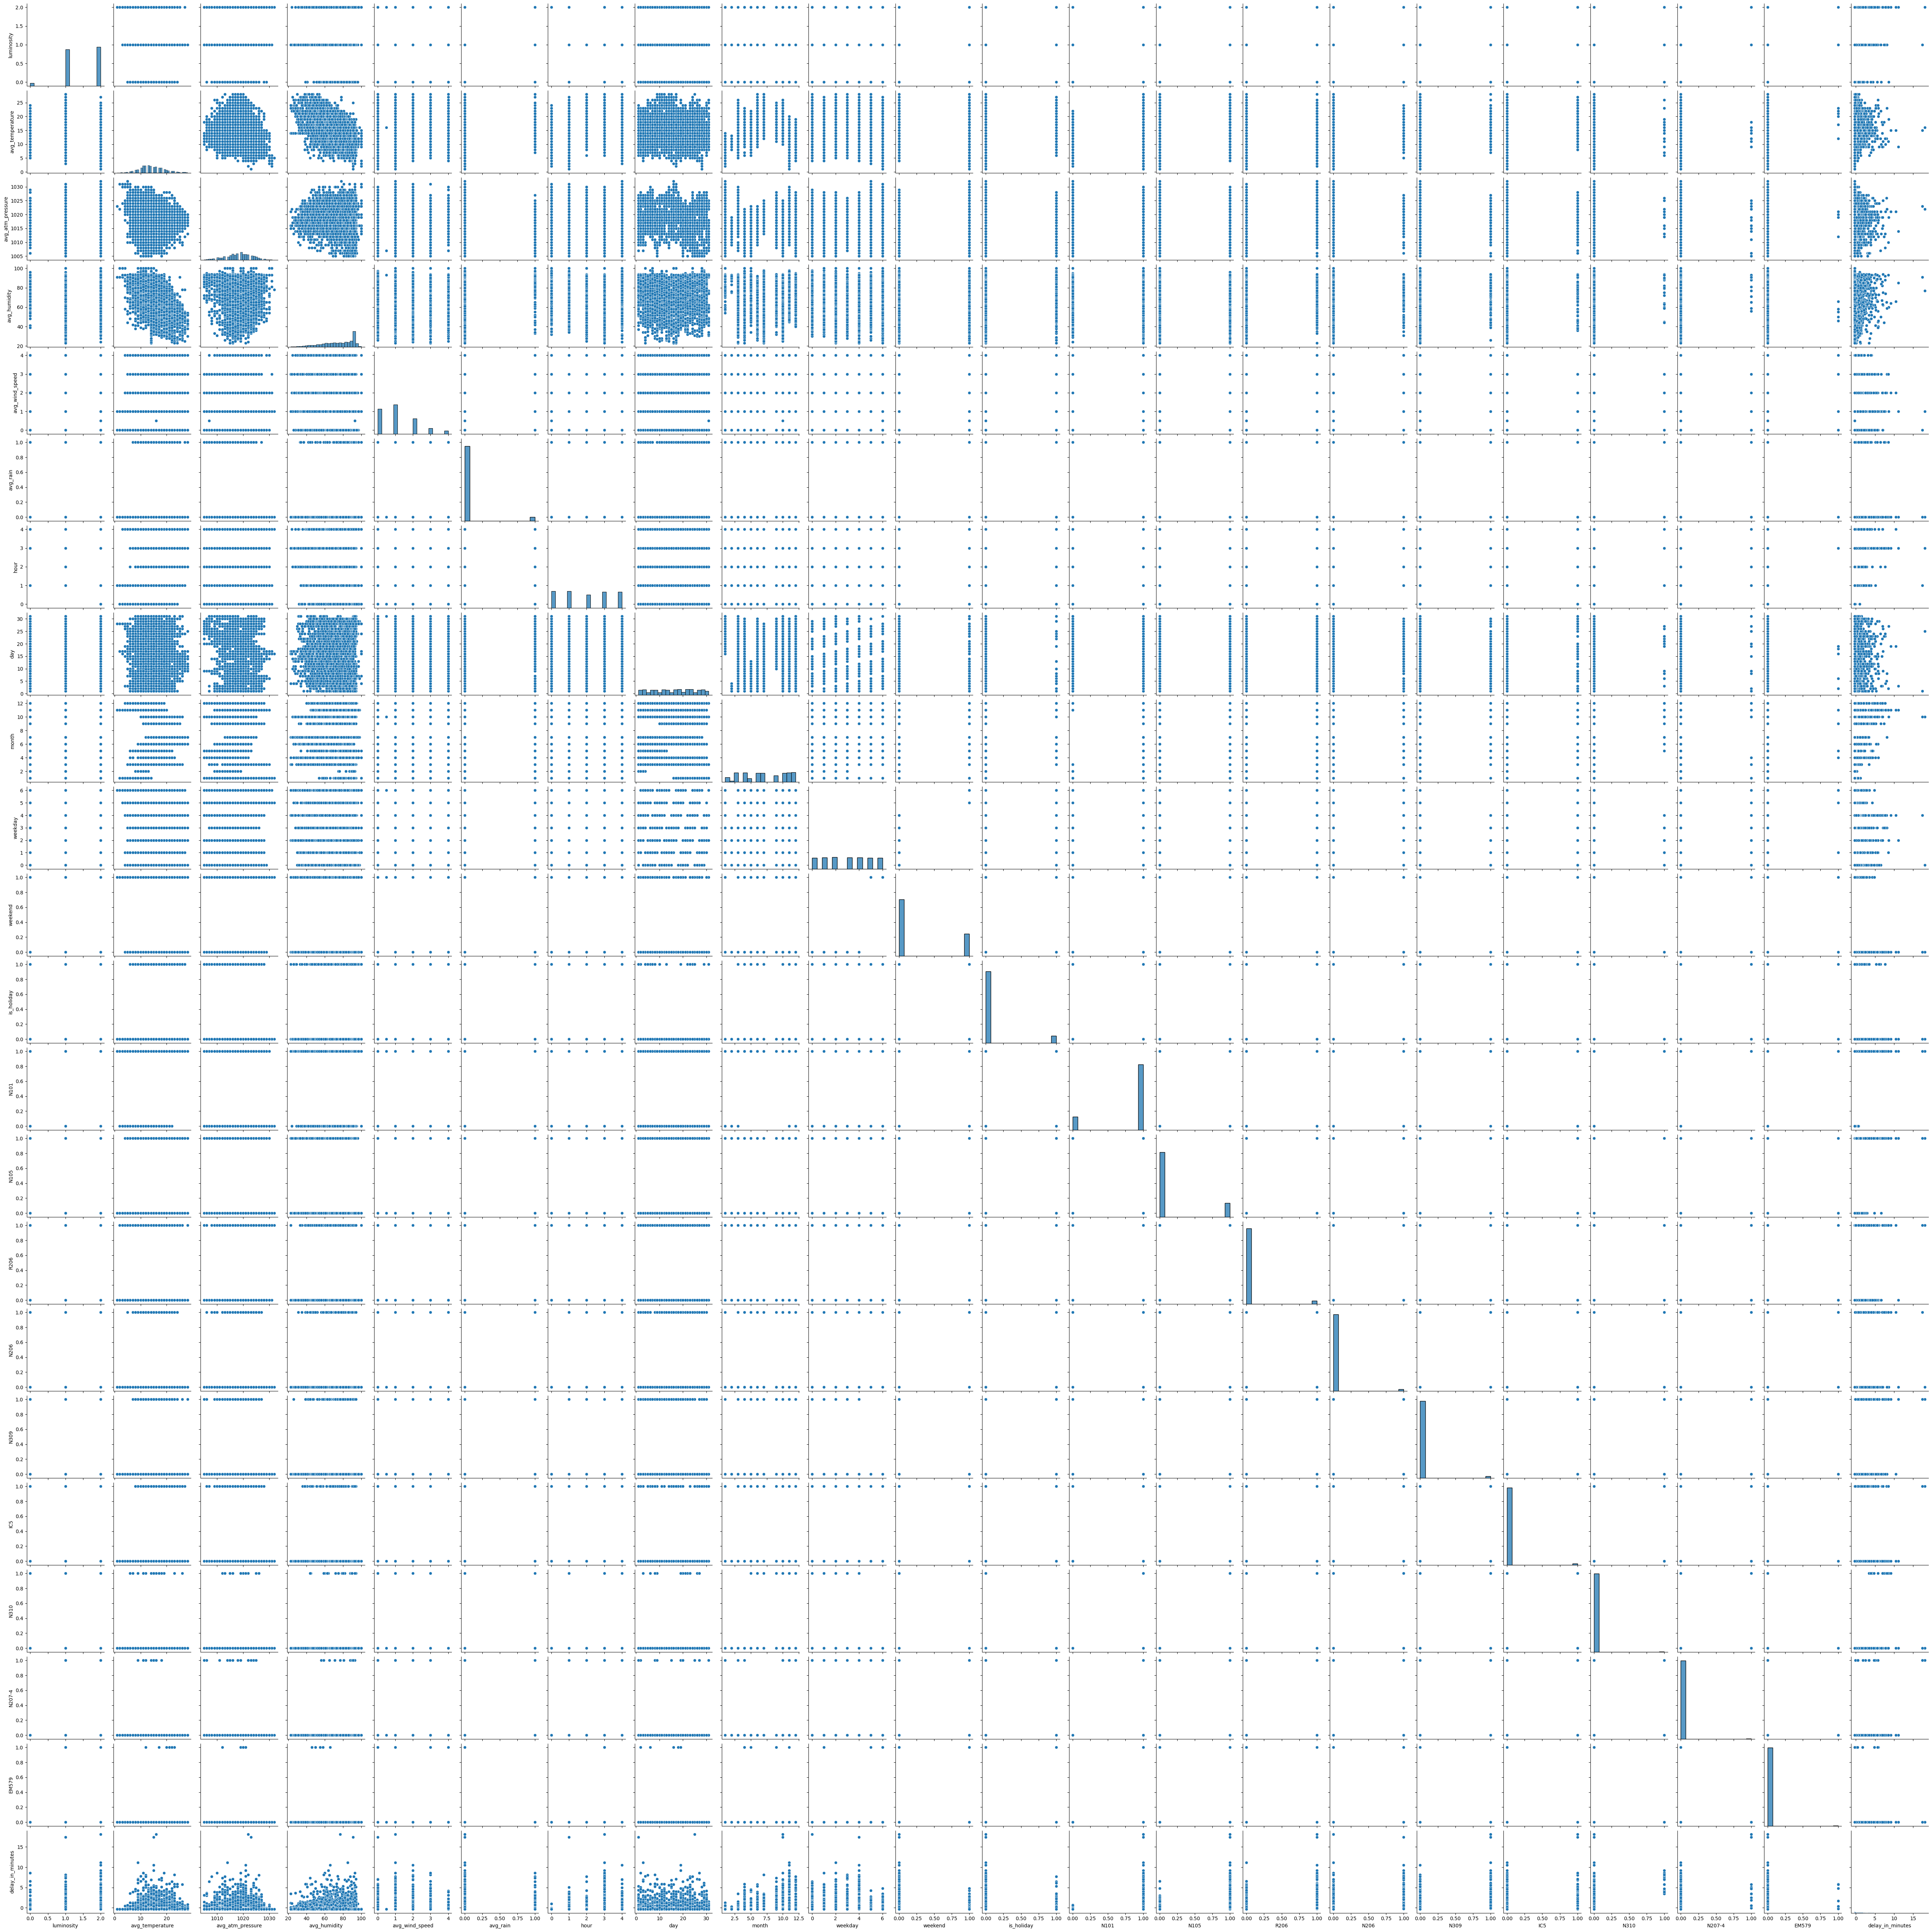

In [12]:
sns.pairplot(prep_df)

- Diagrama de caixa para cada feature numérica

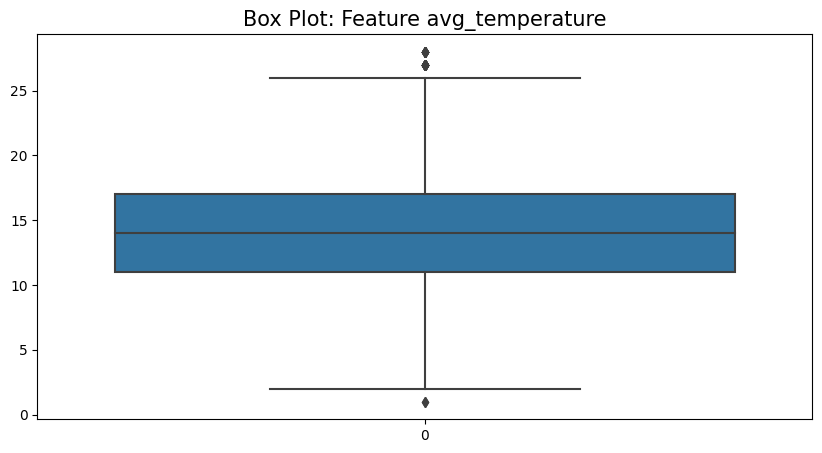

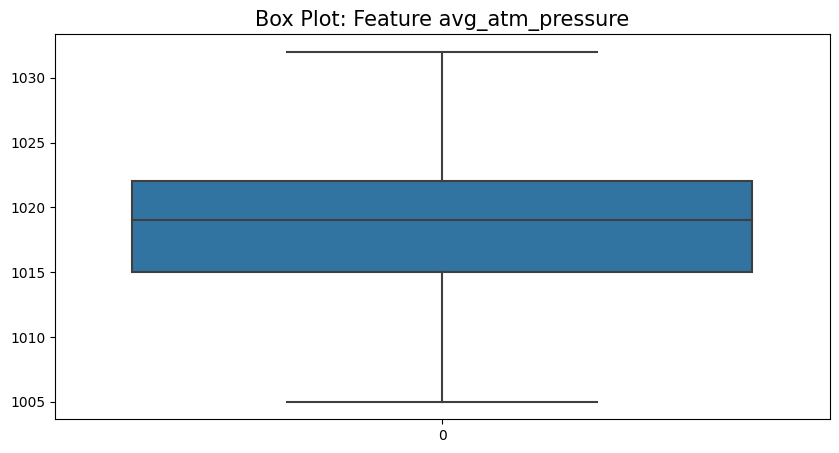

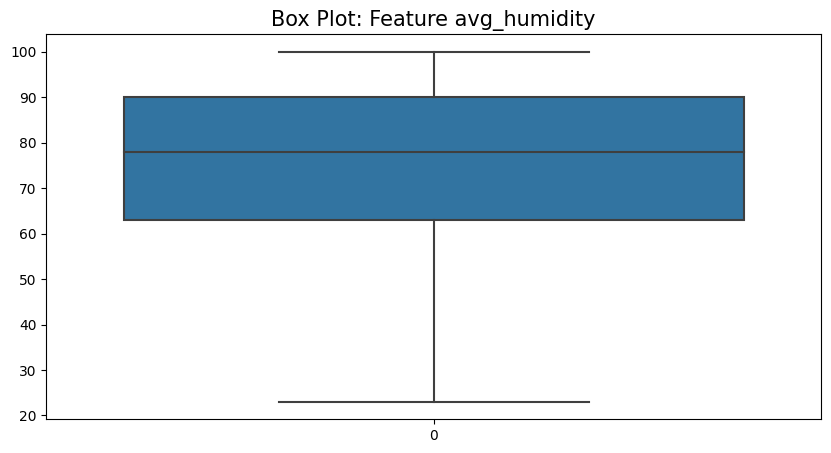

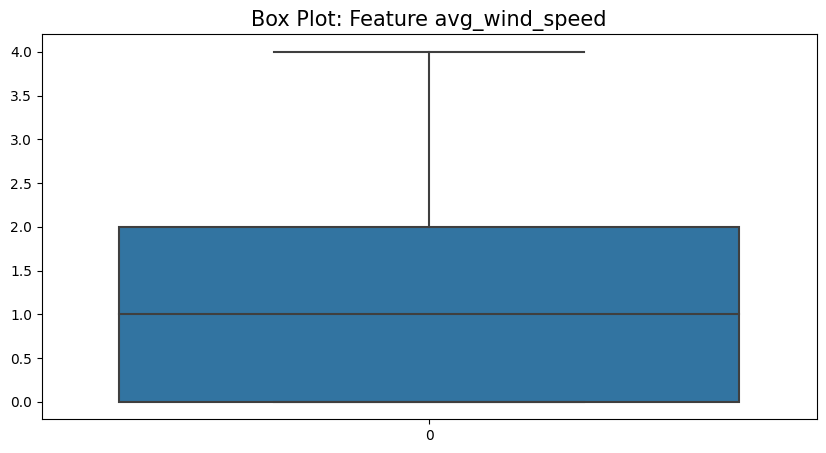

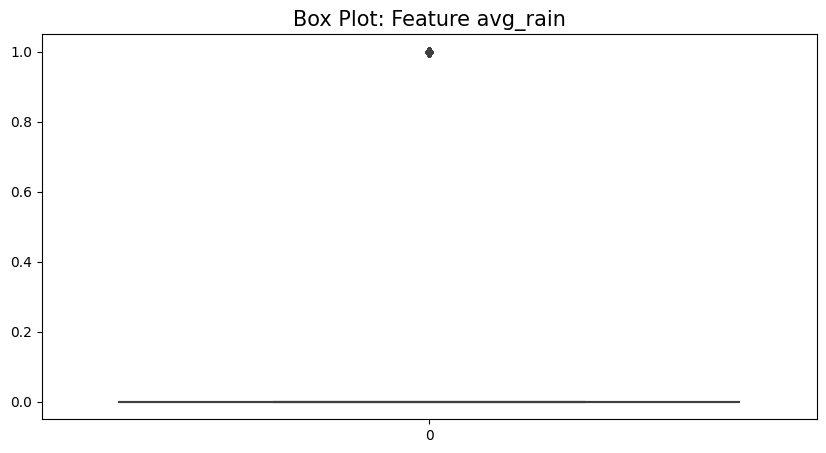

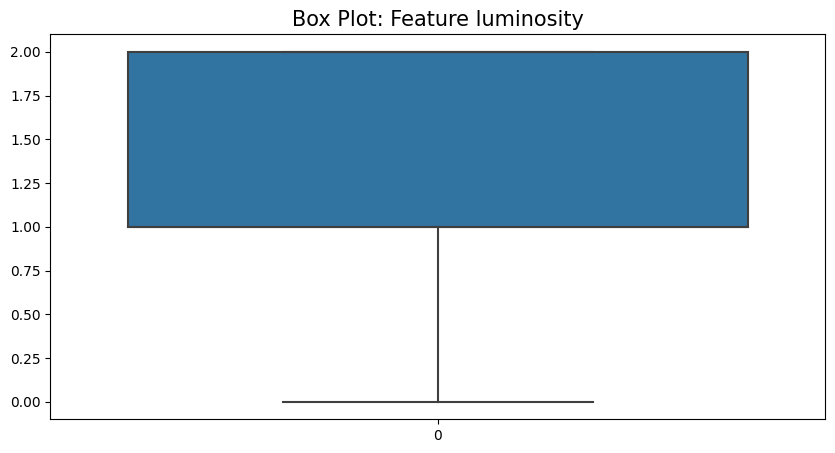

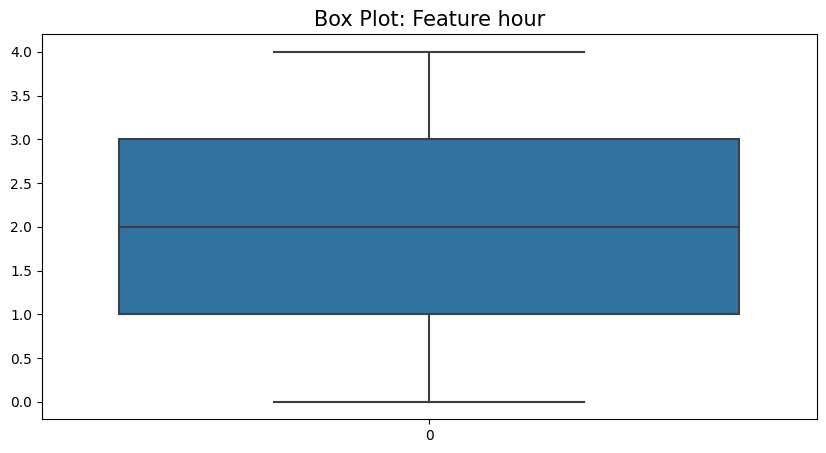

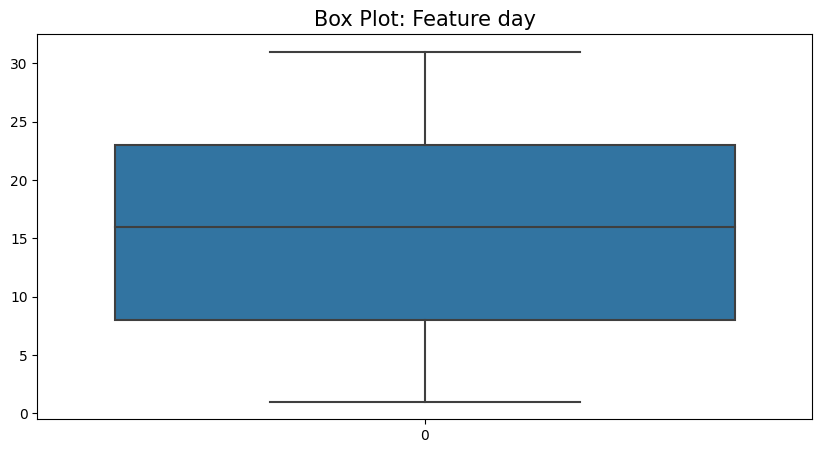

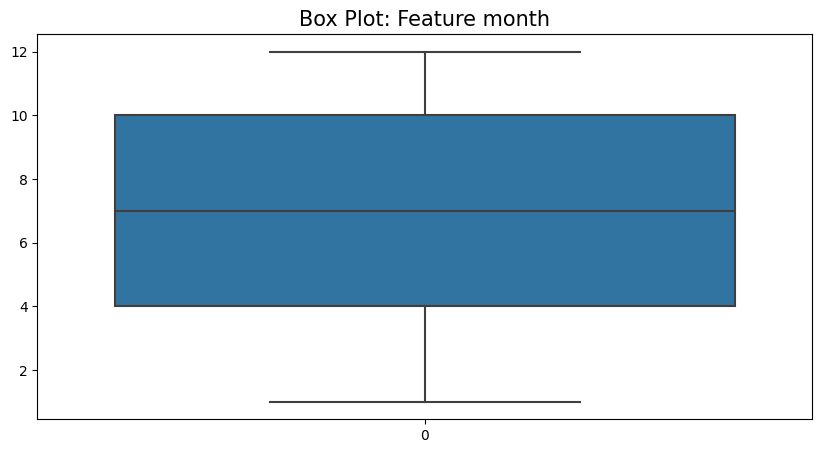

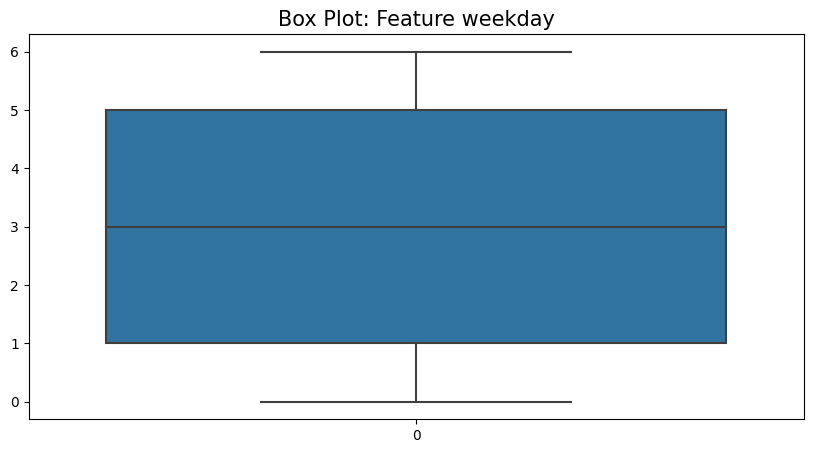

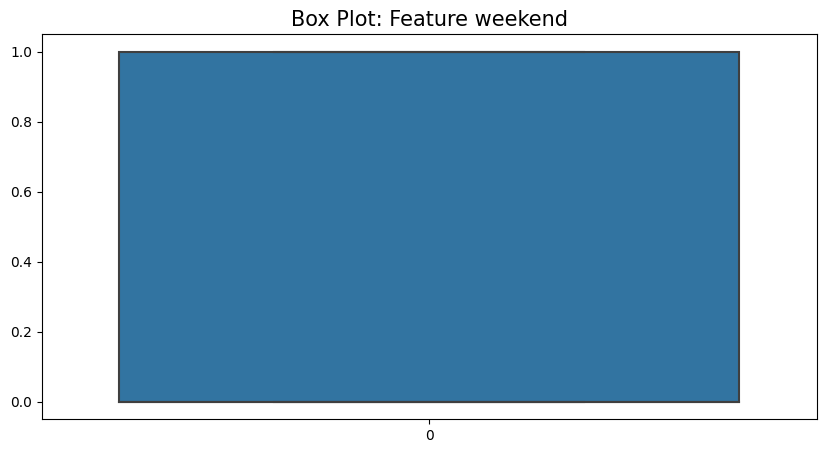

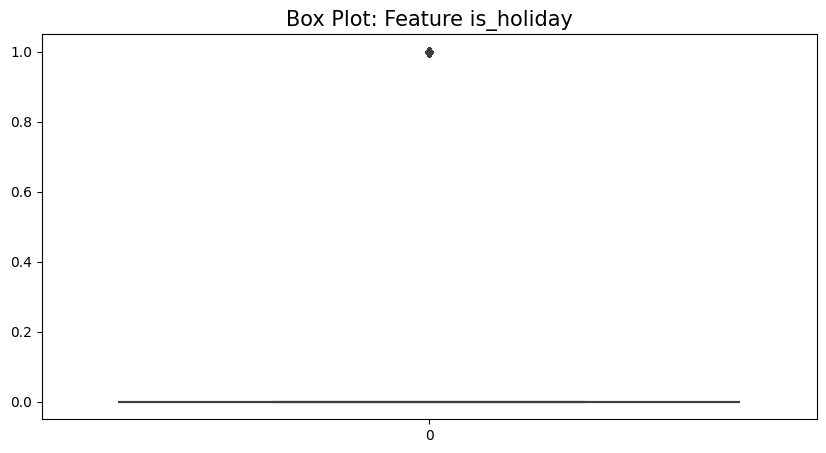

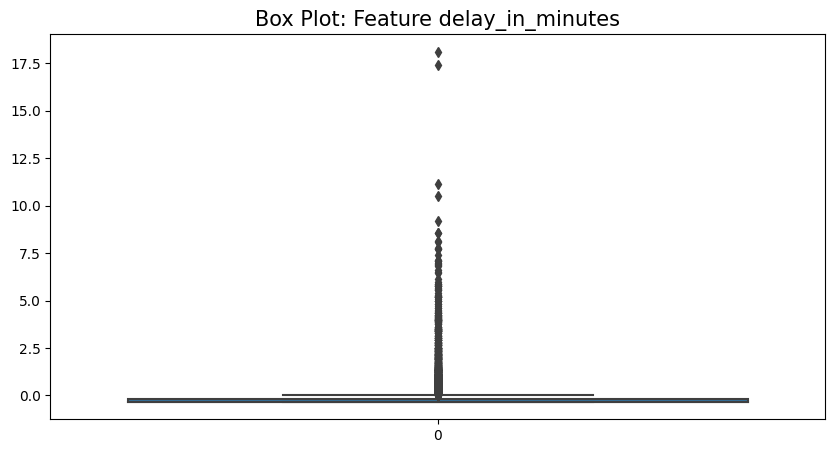

In [13]:
for num in numeric_columns:
    fig = plt.figure(figsize=(10,5))
    sns.boxplot(prep_df[num])
    plt.title('Box Plot: Feature ' + num, fontsize=15)
    plt.show()

- Quantidade de valores nulos em cada feature

<AxesSubplot: >

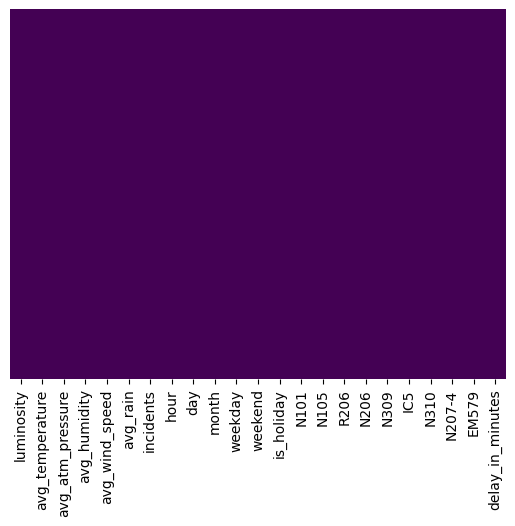

In [14]:
sns.heatmap(prep_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

- Histograma de um conjunto univariante de observações da feature **incidents** (target)

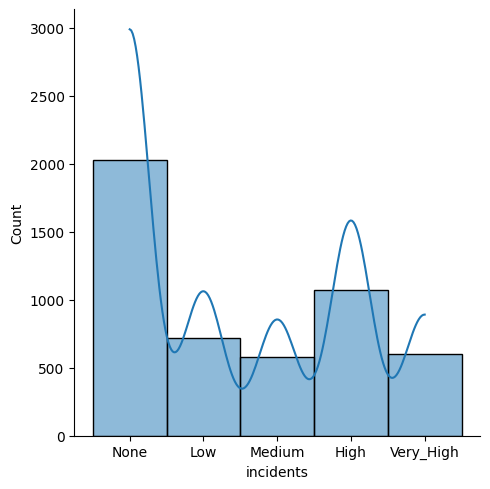

In [15]:
prep_df['incidents'].unique()
prep_df['incidents'] = pd.Categorical(prep_df['incidents'], categories=['None', 'Low', 'Medium', 'High', 'Very_High'])
sns.displot(prep_df['incidents'], kde=True)

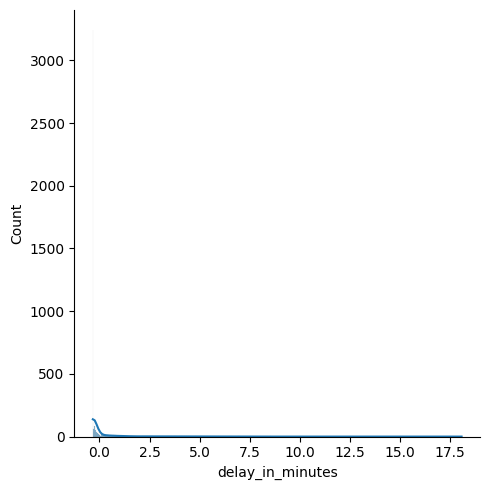

In [16]:
sns.displot(prep_df['delay_in_minutes'], kde=True)